In [40]:
%pip install -qU langchain-google-vertexai langchain-cohere python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [43]:
from langchain_google_vertexai import ChatVertexAI
from langchain_google_vertexai import VertexAIEmbeddings
from google.oauth2.service_account import Credentials
import os
from langchain_cohere import ChatCohere
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
creds = Credentials.from_service_account_file("kubeflowdemo-378213-87173ab3386e.json")

# Chatbot

In [77]:
#llm = ChatVertexAI(model="gemini-1.5-flash", credentials=creds
llm = ChatCohere(model="command-r-plus")

In [68]:
%pip install langchain_google_genai

Note: you may need to restart the kernel to use updated packages.


In [80]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [74]:
llm.invoke("Whats up")

AIMessage(content="Not much, just hanging out and waiting to answer your questions. What's up with you?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-57fcee0f-93b6-4aa8-97e8-04a6b85eded4-0', usage_metadata={'input_tokens': 3, 'output_tokens': 21, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}})

# Embedding Model

In [4]:
from langchain_core.embeddings import Embeddings
import requests

class MyEmbeddingModel(Embeddings):
    def __init__(self, service_url='http://127.0.0.1:8080/predictions/my_model'):
        self.service_url = service_url

    def embed_query(self, text):
        payload = {"input": [text]}
        response = requests.post(self.service_url, json=payload)

        if response.status_code == 200:
            return response.json()[0]
        else:
            raise ValueError(f"Error {response.status_code}: {response.text}")

    def embed_documents(self, texts):
        payload = {"input": texts}
        response = requests.post(self.service_url, json=payload)

        if response.status_code == 200:
            return response.json()
        else:
            raise ValueError(f"Error {response.status_code}: {response.text}")

In [5]:
embeddings = MyEmbeddingModel()

# Vector Store

In [6]:
%pip install -qU langchain-chroma

Note: you may need to restart the kernel to use updated packages.


In [7]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)

# Indexing

In [21]:
%pip install beautifulsoup4 langchain-text-splitters langchain-community

  Using cached langchain_text_splitters-0.3.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached SQLAlchemy-2.0.35-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.6.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached frozenlist-1.5.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached multidict-6.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.0 kB)
  Using cached marshmallow-3.23.1-py3-none-any.whl.metadata (7.5 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached greenlet-3.1.1-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (3.8 kB)
  Using cached mypy_extensions-1

### Loading Documents

In [8]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43131


In [9]:
len(docs)

1

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,  # chunk size (characters)
    chunk_overlap=20,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)

In [18]:
all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 611 sub-documents.


In [19]:
document_ids = vector_store.add_documents(documents=all_splits)

In [22]:
print(document_ids[:3])

['d4a1741b-953a-482e-84be-d3cf2ca3e1a2', 'e8f9cf2a-2af8-4891-b87a-19b6d3f25bf4', 'f32f5d37-baad-487e-9c4d-0a94973f09a7']


# Retrieval and Generation

### Prompt

Using prompt checked in at LangChain prompt hub.

In [23]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

/home/supreet/projects/gemini_hands_on/.conda/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


### LangGraph

#### State
To keep track of the input question, retrieved context, and generated answer

In [29]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

#### Nodes (application steps)
Simple sequence of two steps: retrieval and generation.

In [45]:
def retrieve(state : State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content= "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({
        "context": docs_content, "question": state["question"]
    })
    response = llm.invoke(messages)
    return {"answer": response.content}
    

#### Control flow
We compile the application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [32]:
%pip install langgraph

  Using cached msgpack-1.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
Using cached msgpack-1.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (403 kB)
Note: you may need to restart the kernel to use updated packages.


In [46]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

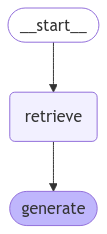

In [35]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### Invoke

In [49]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}')
print(f'Result: {result["answer"]}')

Context: [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1770}, page_content='Task Decomposition#'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2584}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 627}, page_content='Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals,'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39736}, page_content='Challenges in long-term planning and task decomposition: Planning over a lengthy history and')]
Result: Task decomposition is a technique where large tasks are broken down into smaller, more manageable subgoals. This can be done by LLMs with simple prompts, asking for steps to compl

# Query Analysis

We can rewrite user's raw query into more effective search queries. For example, adding some rewriting the query to correct the wording.

In our example we filter for metadata value in the retrieved docs after retrieving the metadata value from user's raw input query.

In [51]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i<third:
        document.metadata["section"]="beginning"
    elif i<2*third:
        document.metadata["section"]="middle"
    else:
        document.metadata["section"]="end"
        
all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

We got to reinsert these processed docs in the vector db after adding the schema. We will use simple ```InMemoryVectorStore``` for storing these docs.

In [52]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

### Structured Output
Models reply in Natural Language, Structured Output allows the models to output in a structured format. \
Lets Define a schema for out search query (user input query).

In [53]:
from typing import Literal

from typing_extensions import Annotated

class Search(TypedDict):
    query : Annotated[str, ..., "Search query to run."]
    section: Annotated[
            Literal["beginning", "middle", "end"],
            ...,
            "Section to query."
        ]

In [54]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

In [70]:
def analyze_query(state: State):
    structured_llm= llm.with_structured_output(Search)
    query=structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"]
    )
    return {"context": retrieved_docs}

#### Control flow

In [72]:
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

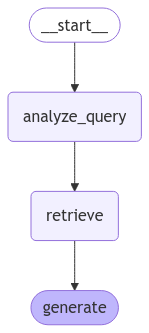

In [57]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [79]:
for step in graph.stream(
    {"question": "What does end say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'end task decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='55451c66-5cbf-4ee9-ae82-d365a2c06fe5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39736, 'section': 'end'}, page_content='Challenges in long-term planning and task decomposition: Planning over a lengthy history and'), Document(id='e9ab1fef-87c0-4724-a412-e07f2c557d60', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 35279, 'section': 'end'}, page_content='end, implemented as code.\\nMake sure that every detail of the architecture is, in the end,'), Document(id='236a4189-4d3c-40c8-beb5-3349c48638c9', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 40423, 'section': 'end'}, page_content='focuses on parsing model output.'), Document(id='03877bf1-3779-47d5-ba9b-a72a966c456d', metadata={'source': 'https://lilianweng.git

In [81]:
structured_llm= llm.with_structured_output(Search)
#query=structured_llm.invoke(state["question"])

ValueError: no signature found for builtin type <class 'dict'>